In [1]:
#am importat librariile de care vom avea nevoie
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
import pathlib

In [3]:
#montam google drive la google colab
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)


Mounted at /content/drive/


In [4]:
#atribuim calea de care avem nevoie
data_dir = "/content/drive/MyDrive/dataset1"
data_dir = pathlib.Path(data_dir)

In [5]:
from PIL import Image

In [6]:
#glob imi returneaza un iterator cu obiecte de tip path - practic amd devine o lista
#amd = list(data_dir.glob('training/amd*'))
#Image.open(str(amd[0]))  #Opens and identifies the given image file.

In [7]:
#normal = list(data_dir.glob('normal/*'))
#Image.open(str(normal[3]))  #Opens and identifies the given image file.

In [8]:
#batch= nr de exemple (in acest caz, imagini) folosite intr o singura iteratie a antrenamentului.
#Un batch este un set de exemple care sunt procesate in acelasi timp de catre model.
#there is no single "best" batch size, even for a given data set and model architecture.
#You need to trade off training time, memory usage, regularization, and accuracy.

#un grup de n imagini folosite ca intrare pentru model
batch_size  = 32
#out of memorie= batch prea mare
#prea mic -> timp prea mare
#img_height = 512
#img_width = 496
img_height = 512
img_width = 496

In [9]:
#dataset/
#  training/
#     normal/
#      amd/
#  validation/
#      normal/
#      amd/


In [10]:
#functie pentru a incarca si prelucra datele de imagine dintr un director specificat si pentru a crea un obiect de set de date
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b,
#together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir/"dataset1/training",
  validation_split=Image.NONE,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1805 files belonging to 2 classes.


In [11]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir/"dataset1/validation",
  validation_split=Image.NONE,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 438 files belonging to 2 classes.


In [12]:
#aici putem gasi numele claselor
class_names = train_ds.class_names
print(class_names)
class_names = validation_ds.class_names
print(class_names)

['amd', 'normal']
['amd', 'normal']


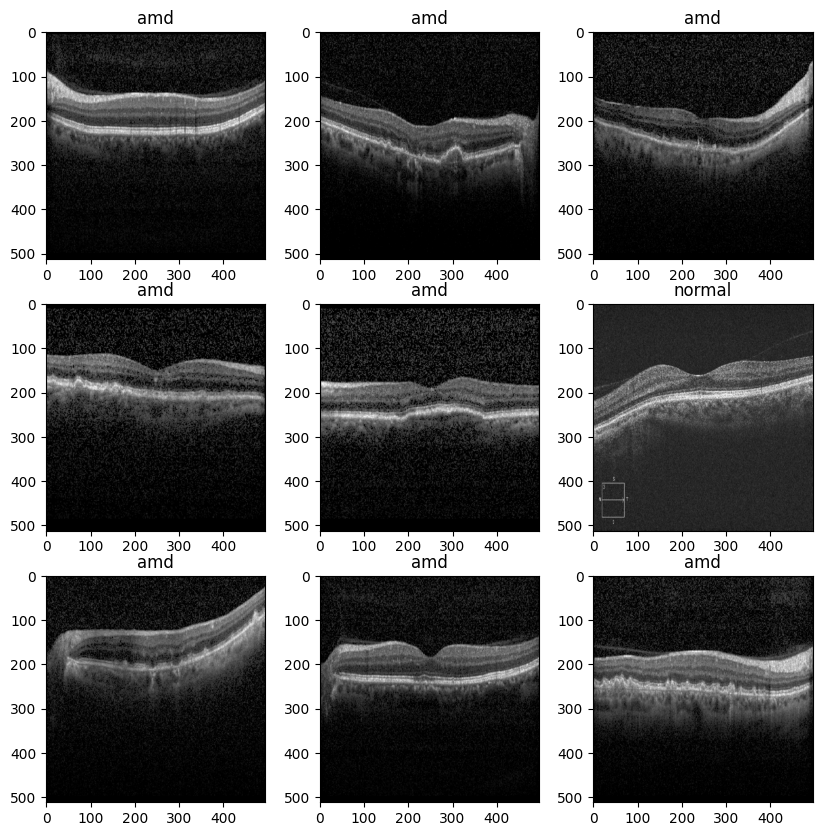

In [13]:
#9 imagini din datasetul training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

In [14]:
####transmitem aceste seturi de date functiei de mai jos pt antrenament mai tarziu####
#(32): Acesta este nr de imagini din lot. In acest caz, sunt 32 de imagini intr-un lot.
#(512 si 496): Reprezinta dim. imaginilor
#(3): Reprezinta nr de canale pt fiecare imagine.
#(32):vector de etichete pentru cele 32 de imagini din lot
for image_batch,labels_batch in train_ds :
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 496, 3)
(32,)


In [15]:
#AUTOTUNE este o constanta care poate fi folosita pt a optimiza performanta
#seturilor de date in timpul executiei
#Dataset.cache():memoreaza datele in memoria RAM sau disc pt a imbunatati performanta
#Se amesteca 1000 de date din dataset training->ordinea datelor din dataset training
#este aleatorizata inainte de fiecare epoca de antrenament
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1050).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [16]:
num_classes = len(class_names)
print(num_classes ,':',class_names)

2 : ['amd', 'normal']


In [17]:
#DEFINIRE MODEL SECVENTIAL

In [18]:


#il definesc ca o lista de layere

model = Sequential([
   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters = 32, kernel_size = (5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size = (2, 2), strides = 2),
    layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2), strides = 2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation = 'softmax')
])



#relu imi face max(0,val_ponder_neuron)  ->
# neuronii trebuie sa aiba val intre 0 si 1
# daca pt intrare valorile sunt <=0 -> le pune 0 si le dezactiveaza
# daca pt intrare valorile sunt >0 -> le pune val lor si le activ

# doar pt layerele de intrare  ->pun  input_shape



In [19]:
# optimizare MODEL

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#SGD - optimizeaza eroarea intre ce prezice reteaua si ce este de fapt
# va face un update la pondere cu val grad * rata de invatare

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 496, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 508, 492, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 246, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 242, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 121, 64)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 64)                0

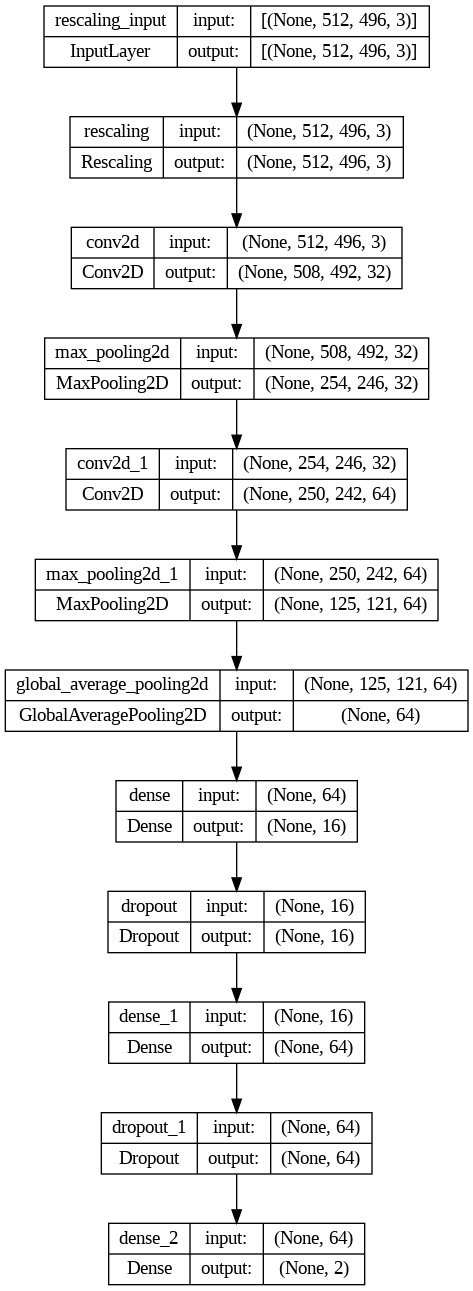

In [21]:
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
epochs=60
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs)

Epoch 1/60
57/57 [==============================] - 257s 2s/step - loss: 0.6859 - accuracy: 0.5551 - val_loss: 0.6743 - val_accuracy: 0.6279
Epoch 2/60
57/57 [==============================] - 13s 223ms/step - loss: 0.6572 - accuracy: 0.6205 - val_loss: 0.6576 - val_accuracy: 0.6210
Epoch 3/60
57/57 [==============================] - 13s 222ms/step - loss: 0.6295 - accuracy: 0.6499 - val_loss: 0.6130 - val_accuracy: 0.6256
Epoch 4/60
57/57 [==============================] - 13s 222ms/step - loss: 0.5919 - accuracy: 0.6920 - val_loss: 0.5857 - val_accuracy: 0.6941
Epoch 5/60
57/57 [==============================] - 13s 222ms/step - loss: 0.5705 - accuracy: 0.7202 - val_loss: 0.5759 - val_accuracy: 0.7146
Epoch 6/60
57/57 [==============================] - 13s 222ms/step - loss: 0.5664 - accuracy: 0.7280 - val_loss: 0.5669 - val_accuracy: 0.7215
Epoch 7/60
57/57 [==============================] - 13s 226ms/step - loss: 0.5593 - accuracy: 0.7324 - val_loss: 0.5661 - val_accuracy: 0.7215
E

# New Section

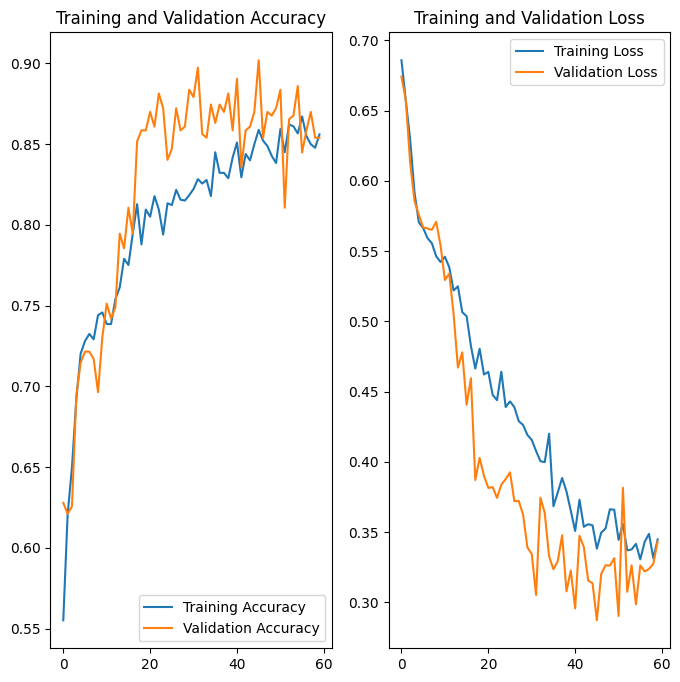

In [23]:
#vizualizam rezultatele intr un grafic
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#daca pe grafic validation loss -> prima data scade iar apoi incepe sa creasca -> am overfitting
#pentru a rezolva problema supraajustarii, am nevoie de o modalitate de a surprinde complexitatea unui model, adica cat de complex poate fi modelul.
#Un model = un vector de ponderi. (weights)
#Prin urmare, complexitatea unui model poate fi reprezentata convenabil ca nr de ponderi diferite de zero.


#sau daca metricile pt validation sunt considerabil mai slabe decat cele pt antrenament-> overfitting
# ca sa reduc overfitting-ul -> reduc complexitatea ->simplific modelul scazand nr de neuroni sau eliminand layere
#->data augmentation
#-> dropout ->ignora random un subset de neuroni dintr un layer in timpul antrenamentului , va ajuta modelul la generalizarea datelor pe care nu le a vazut inca (la predictie)
#cand facem droput trebuie sa specific procentul de neuroni dintr un layer

#underfitting -> cand modelul nu este antrenat destul de bine si nu poate face predictii precise pe datele noi de testare sau validare
#daca pt antrenament valorile pt loss sunt crescute iar pentru acuratete sunt mici
#1. incerc sa cresc complexitatea adaug. layere crescand nr de neuroni pt fiecare layer sau schimband tipul de layer
#2. adaugarea de caracteristici noi pt date pt a face clasificarea mai buna
#3. sa reduc droput

In [40]:

# Directorul in care se afla imaginile
dir_path = "/content/drive/MyDrive/dataset1/dataset1/test/"

# Dimensiunile imaginilor incarcate
img_height, img_width = 512, 496

# Lista cu numele tuturor imaginilor din director
imagini = os.listdir(dir_path)

# Am afisat toate numele imaginilor care sunt in director
print(imagini)

# Se alege un fisier aleator
imagine_random = random.choice(imagini)

# Construim calea fisierului ales
img_path = dir_path + imagine_random

# incarcam imaginea si o pregatim pentru a fi utilizata in model
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img) # se converteste imaginea intr un tablou numpy de valori de tip float, transformand imaginea intr o reprezentare numerica pe care o poate manipula nn
img_array = tf.expand_dims(img_array, 0)  # creeam un batch cu o singura imagine

#print(img_array)

# Facem predictii cu modelul
predictii = model.predict(img_array)
score = tf.nn.softmax(predictii[0])

# afisam rezultatul
print(
    "Imaginea cu numele {} apartine cel mai probabil clasei {}, avand {:.2f} % rata de incredere."
    .format(imagine_random, class_names[np.argmax(score)], 100 * np.max(score))
)


['NORMAL-12494-1.jpeg', 'NORMAL-12494-2.jpeg', 'NORMAL-112928-1.jpeg', 'NORMAL-119840-1.jpeg', 'NORMAL-12494-5.jpeg', 'NORMAL-12494-4.jpeg', 'NORMAL-197082-1.jpeg', 'NORMAL-138971-1.jpeg', 'NORMAL-15307-1.jpeg', 'NORMAL-101880-1.jpeg', 'NORMAL-133321-1.jpeg', 'NORMAL-12494-3.jpeg', 'NORMAL-153950-1.jpeg', 'NORMAL-15208-1.jpeg', 'NORMAL-269181-1.jpeg', 'NORMAL-307151-1.jpeg', 'NORMAL-283376-1.jpeg', 'NORMAL-307151-2.jpeg', 'NORMAL-223814-1.jpeg', 'NORMAL-279206-1.jpeg', 'NORMAL-285896-1.jpeg', 'NORMAL-402066-3.jpeg', 'NORMAL-366503-1.jpeg', 'NORMAL-395557-1.jpeg', 'NORMAL-338568-1.jpeg', 'NORMAL-366503-2.jpeg', 'NORMAL-402066-5.jpeg', 'NORMAL-438684-3.jpeg', 'NORMAL-36734-1.jpeg', 'NORMAL-33637-1.jpeg', 'NORMAL-447690-2.jpeg', 'NORMAL-402066-2.jpeg', 'NORMAL-438684-1.jpeg', 'NORMAL-402066-1.jpeg', 'NORMAL-330905-1.jpeg', 'NORMAL-443980-1.jpeg', 'NORMAL-402066-4.jpeg', 'NORMAL-438684-2.jpeg', 'NORMAL-33350-1.jpeg', 'NORMAL-446851-1.jpeg', 'NORMAL-33350-3.jpeg', 'NORMAL-349021-1.jpeg', 'N